In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Paramètres

In [85]:
L = 10 #time horizon
nb_iter = 2500 #nb d'itérations pour la simulation de Montecarlo
m = 30 #dimension de l'espace de projection

X_0 = 100 # prix initial
K_0 = 85 #strike
sigma = 0.2 # volatility

valeurs_sigma = np.linspace(0.05, 0.25, 10)
valeurs_strike = np.linspace(85, 120, 10)

In [16]:
dW = np.random.normal(loc=0, scale=1, size=(nb_iter, L))

W = np.concatenate((np.zeros((nb_iter, 1)), np.cumsum(dW, axis=1)), axis=1)  #simulation de N mouvements browniens


def calculate_X_t(X_0, sigma, W, t, n):
    drift_term = - (sigma**2) * t / 2
    diffusion_term = sigma * W[n,t]
    X_t = X_0 * np.exp(diffusion_term + drift_term)
    return X_t


X = np.zeros(shape = (nb_iter, L+1))

for n in range(nb_iter):
    for j in range(L+1):
        X[n,j] = calculate_X_t(X_0, sigma, W, j, n)
        

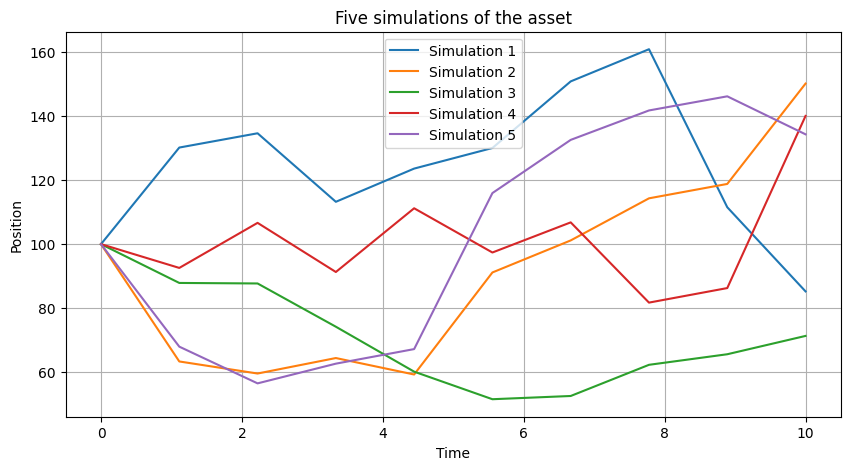

In [31]:
# Plot du mouvement brownien

t = np.linspace(0, L, L)
plt.figure(figsize=(10, 5))
for k in range(5):
    plt.plot(t, X[k,0:L], label='Simulation {}'.format(k+1))
plt.title('Five simulations of the asset')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.show()

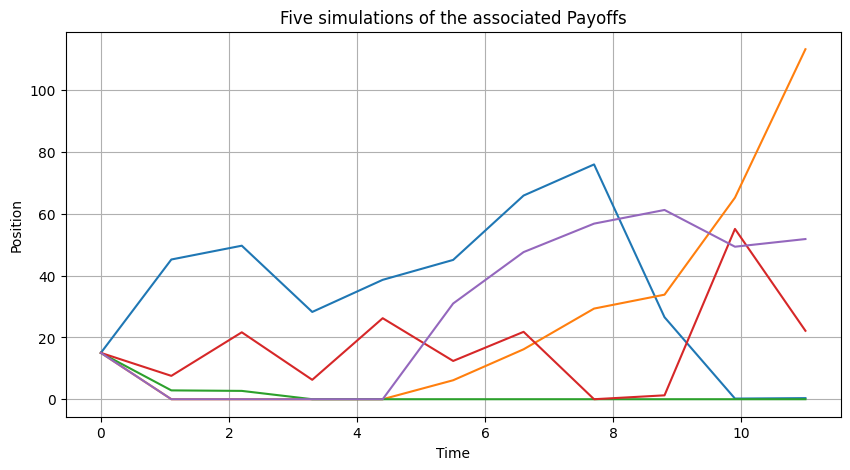

In [18]:
Z = np.maximum(X - K_0, 0)
plt.figure(figsize=(10, 5))
for k in range(5):
    plt.plot(t, Z[k,:])
plt.title('Five simulations of the associated Payoffs')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.show()

In [19]:
tau = np.zeros(shape = (nb_iter,L),dtype=int)
alpha = np.zeros(shape = (L-1,m))
tau[:,L-1] = L #initialisation

In [74]:
def e(i,x):
    return x**i


def vect_e(m,x):
    res = np.zeros(shape = m)
    for i in range(m):
        res[i] = e(i, x)
    return res


def indicatrice(n,j,Z, X): # j est le temps, n représente l'itération numéro de l'itération
    return int( Z[n,j] >= np.dot(alpha[j], vect_e(m,X[n,j])))


def indicatrice_barre(n,j, Z, X):
    return 1 - indicatrice(n,j, Z, X)

    
def tau_precedent(n,j,Z,X):
    return j * indicatrice(n,j,Z,X) + tau[n, j+1] * indicatrice_barre(n,j,Z,X)

def compute_alpha_pol(j, Z, X, nb_iters):
    a = np.zeros(shape = m)
    def error_function(a):
        error = 0
        for n in range(nb_iters):
            error += (Z[n,tau[n,j+1]] - np.dot(a, vect_e(m,X[n,j]))) **2
        return error
    result = minimize(error_function, a, method = 'Powell')
    return result

# Calcul de tau et alpha

In [69]:
for j in range(L-2,-1,-1):
    alpha[j] = compute_alpha_pol(j, Z , X, nb_iter).x
    for n in range(nb_iter):
        tau[n,j] = tau_precedent(n,j,Z,X)

In [70]:
print(tau[:100,0]) #je plot les tau de chaque simulation pour vérifier que les temps d'arrêts sont bien différents à chaque fois 

[ 6 10 10 10  7 10  7  4  7  7 10  8  8 10  4  6 10  7 10  4 10 10 10 10
  8  8 10  6  5  5  6  6  3 10 10 10 10  5 10  7  7  5 10 10  5  5 10 10
 10 10 10  6 10 10  8 10  4  5  3  8  4  7 10  3  4  4  4  4  5 10  4  5
 10 10  5  5 10  8 10 10  6  4 10  4 10  4 10 10  4  6 10  8  7  3  4  4
 10 10  4 10]


In [71]:
somme_Z_tau = 0
for n in range(nb_iter):
    somme_Z_tau += Z[n, tau[n,0]]
   
price_montecarlo  = max(Z[0,0], somme_Z_tau/ nb_iter)
print(f' The option price is : {price_montecarlo}')

 The option price is : 31.914087102385576


In [76]:
def compute_premium(L, nb_iters, m, X_0, K, sigma, option_type = 'call'):
    # fonction qui calcule le prix de l'option en fonction des paramètres
    dW = np.random.normal(loc=0, scale=1, size=(nb_iters, L))
    W = np.concatenate((np.zeros((nb_iters, 1)), np.cumsum(dW, axis=1)), axis=1)  #simulation de N mouvements browniens
    X = np.zeros(shape = (nb_iters, L+1))
    for n in range(nb_iters):
        for j in range(L+1):
            X[n,j] = calculate_X_t(X_0, sigma, W, j, n)
    if option_type == 'call':
        Z = np.maximum(X - K, 0)
    else:
        Z = np.maximum(K - X, 0)
    tau = np.zeros(shape = (nb_iters,L),dtype=int)
    alpha = np.zeros(shape = (L-1,m))
    tau[:,L-1] = L #initialisation
    for j in range(L-2,-1,-1):
        alpha[j] = compute_alpha_pol(j, Z, X, nb_iters).x
    for n in range(nb_iters):
        tau[n,j] = tau_precedent(n,j, Z, X)
    somme_Z_tau = 0
    for n in range(nb_iters):
        somme_Z_tau += Z[n, tau[n,0]]
    return max(Z[0,0], somme_Z_tau/ nb_iters)


# Influence du strike sur le premium

In [68]:
premium_values1 =  []

for K in valeurs_strike:
    premium_values1.append(compute_premium(L,nb_iter, m, X_0, K, sigma, option_type = 'put'))

KeyboardInterrupt: 

In [48]:
premium_values1
binomial_premium1 = [16.646099631307663, 18.60599436549075, 20.56588909967384, 22.525783833856934, 24.61574027513224, 27.486066958960798, 30.356393642789357, 33.22672032661793, 36.09704701044649, 38.96737369427505]



scholes_strike = np.array([16.18272117, 18.27413591, 20.47197104, 22.77064638, 25.16467397,
       27.64870544, 30.21756639, 32.8662806 , 35.59008578, 38.38444297])

In [41]:
#binomial
[16.646099631307663, 18.60599436549075, 20.56588909967384, 22.525783833856934, 24.61574027513224, 27.486066958960798, 30.356393642789357, 33.22672032661793, 36.09704701044649, 38.96737369427505]

#scholes
np.array([16.18272117, 18.27413591, 20.47197104, 22.77064638, 25.16467397,
       27.64870544, 30.21756639, 32.8662806 , 35.59008578, 38.38444297])

array([16.18272117, 18.27413591, 20.47197104, 22.77064638, 25.16467397,
       27.64870544, 30.21756639, 32.8662806 , 35.59008578, 38.38444297])

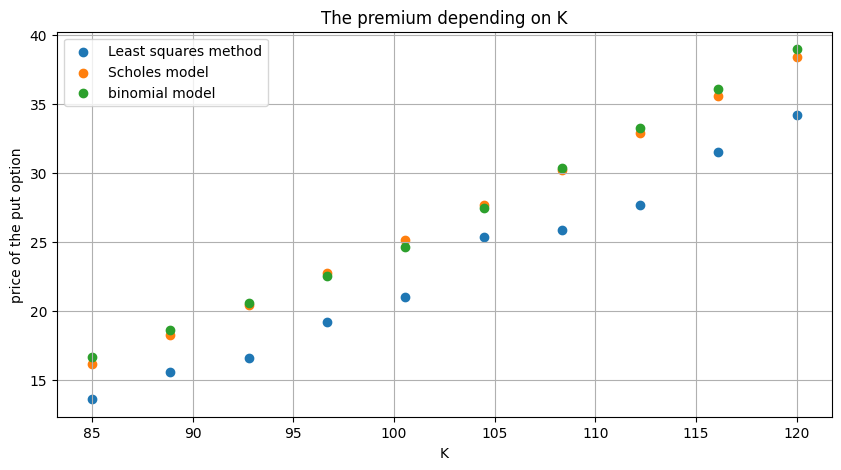

In [51]:
plt.figure(figsize=(10, 5))

plt.scatter(valeurs_strike, premium_values1, label= 'Least squares method')
plt.scatter(valeurs_strike, scholes_strike, label= 'Scholes model')
plt.scatter(valeurs_strike, binomial_premium1, label= 'binomial model')
plt.title('The premium depending on K')
plt.legend()
plt.xlabel('K')
plt.ylabel('price of the put option')
plt.grid(True)
plt.show()

# Influence de sigma sur le premium

In [28]:
premium_values2 =  []

for sigma_ in valeurs_sigma:
    premium_values2.append(compute_premium(L,nb_iter, m, X_0, K_0, sigma_, option_type = 'put'))

premium_values2

[0.71024325188736,
 2.199032031204976,
 3.403709776627222,
 5.648027165723318,
 7.280772536289618,
 10.008733332087244,
 11.967612936528916,
 14.035042460114465,
 15.508280684088529,
 17.941930155481526]

In [29]:
binomial_premium2 =   [1.203507091590142, 2.8756207270314444, 5.034948550033718, 7.518492330311087, 9.983786520228588, 12.427959693972369, 14.848221799169877, 17.24187419401509, 19.606319067547716, 21.939068186380673]

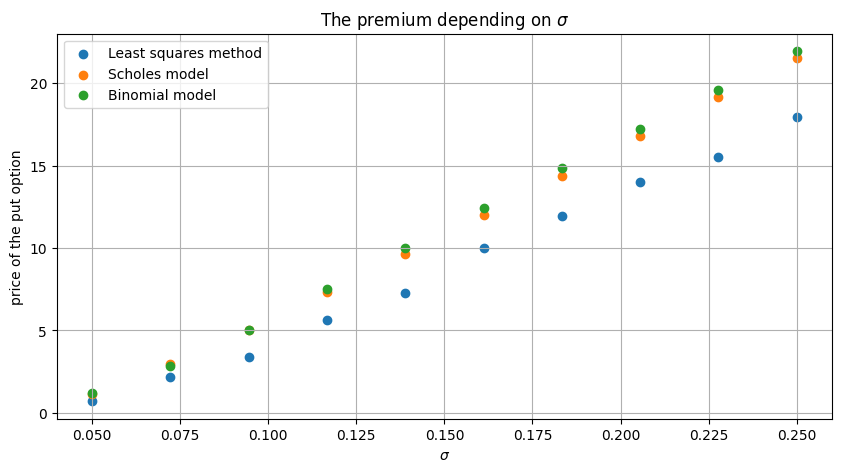

In [30]:
valeurs_sigma = np.linspace(0.05, 0.25, 10)
scholes_sigma = np.array([ 1.14914138,  2.9389606 ,  5.05103614,  7.31213907,  9.64631705,
       12.01518293, 14.39676433, 16.77711271, 19.14658236, 21.49802233])

plt.figure(figsize=(10, 5))
plt.scatter(valeurs_sigma, premium_values2, label= 'Least squares method')
plt.scatter(valeurs_sigma, scholes_sigma, label = 'Scholes model')
plt.scatter(valeurs_sigma, binomial_premium2, label = 'Binomial model')
plt.legend()
plt.title(r'The premium depending on $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel('price of the put option')
plt.grid(True)
plt.show()

# Speed of convergence depending on N

In [86]:
price_montecarlo = compute_premium(L,nb_iter, m, X_0, K_0, sigma, option_type = 'call')

In [91]:
iterations = np.linspace(1000, 5000, 5)
compare_iterations = []

for iter in iterations:
    compare_iterations.append(compute_premium(L, int(iter), m, X_0, K_0, sigma, option_type = 'call'))

IndexError: index 2500 is out of bounds for axis 0 with size 2500

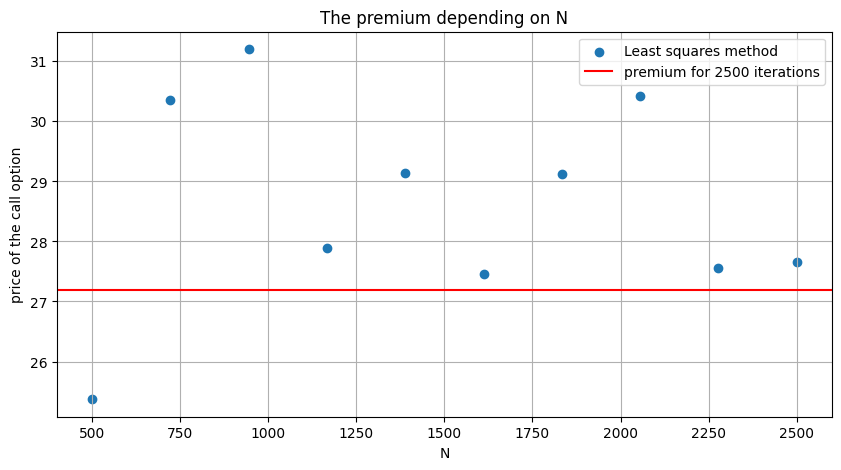

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(iterations, compare_iterations, label= 'Least squares method')
plt.axhline(y=price_montecarlo, color='r', linestyle='-', label='premium for 2500 iterations')
plt.legend()
plt.title('The premium depending on N')
plt.xlabel('N')
plt.ylabel('price of the call option')
plt.grid(True)
plt.show()